In [4]:
import torch
torch.set_default_tensor_type(torch.FloatTensor)
from torch.autograd import Variable
from torch.nn import functional as F
from torchmetrics import Accuracy, Recall, Precision, Specificity, ConfusionMatrix
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix

from sklearn.metrics import precision_recall_curve, average_precision_score,roc_curve, auc, precision_score, recall_score, f1_score, confusion_matrix, accuracy_score

import numpy as np
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

import matplotlib.pyplot as plt
from collections import Counter
import random
import math
import torch.optim as optim
from tabulate import tabulate
from ray import tune

from fractions import Fraction

In [5]:
# Create Tensors to hold input and outputs.
beta_1=np.append(np.array([4,4,-8,-4,6,8,-4,4,-6,4]),np.zeros(90))
beta_2=np.append(np.array([-2,2,4,-2,3,-4,2,-2,-3,2]),np.zeros(90))
beta_3=np.append(np.array([-3,-3,6,-3,-4.5,-6,3,-3,4.5,3]),np.zeros(90))

beta_1=beta_1.reshape(-1,1)
beta_2=beta_2.reshape(-1,1)
beta_3=beta_3.reshape(-1,1)

n1=200
n2=200
n3=200
p=100
corval=0
prior=7

def sigmoid(X):
    return .5 * (1 + np.tanh(.5 * X))

def generate_data(corval,beta,n,p):
    mean=np.zeros(p)
    sigma=np.array([[corval**abs(i-j) for i in range(p)] for j in range(p)])
    x=torch.tensor(np.random.multivariate_normal(mean=mean,cov=sigma,size=n))
    Pi_test= sigmoid(x@beta)
    y=np.random.binomial(1,Pi_test.ravel(),n)
    x=x.to(torch.float32)
    #y=torch.tensor(y,dtype=torch.double)
    y=torch.tensor(y,dtype=torch.float)
    #y=y.to(torch.float32)
    return x,y


In [6]:
def setup_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True
# 设置随机数种子
setup_seed(1)

# generation of training and test data
x1,y1=generate_data(corval,beta_1,n1,p)
x2,y2=generate_data(corval,beta_2,n2,p)
x3,y3=generate_data(corval,beta_3,n3,p)

train_x1, test_x1, train_y1, test_y1= train_test_split(x1,y1, test_size=0.2, random_state=1)
train_x2, test_x2, train_y2, test_y2= train_test_split(x2,y2, test_size=0.2, random_state=1)
train_x3, test_x3, train_y3, test_y3= train_test_split(x3,y3, test_size=0.2, random_state=1)

#test_x1,test_y1=generaet_data(corval,beta_1,n_test,p)
#test_x2,test_y2=generaet_data(corval,beta_2,n_test,p)
#test_x3,test_y3=generaet_data(corval,beta_3,n_test,p)


tensor(0.2181, dtype=torch.float64)

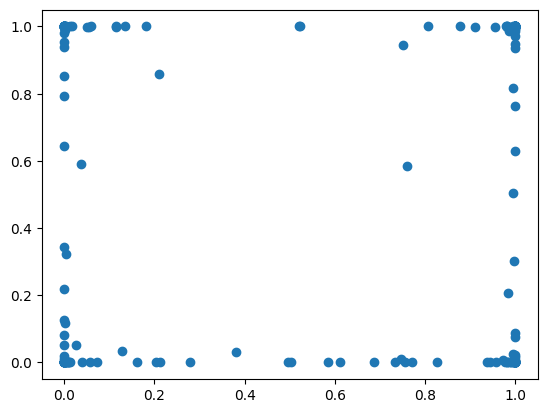

In [7]:
plt.scatter(sigmoid(x3@beta_3).squeeze(),sigmoid(x1@beta_1).squeeze())
sigmoid(x3@beta_3).squeeze().cov()

In [8]:
    # switch training set
    inputs_1,targets_1 = train_x1,train_y1
    inputs_2,targets_2 = train_x2,train_y2
    inputs_3,targets_3 = train_x3,train_y3

    # switching testing set
    test_inputs_1, test_targets_1 = test_x1,test_y1
    test_inputs_2, test_targets_2 = test_x2,test_y2
    test_inputs_3, test_targets_3 = test_x3,test_y3

In [9]:
################## first step##################

# choose lambda1,lambda2 by ray tune

prior=7
class MLP(torch.nn.Module):
    def __init__(self,seed):
        super(MLP, self).__init__()
        torch.manual_seed(seed)
        self.linear1 = torch.nn.Parameter(torch.randn(p))
        self.linear2 = torch.nn.Linear(p,10)
        self.linear3 = torch.nn.Linear(10,1)

    def forward(self, x):
        layer1_out = self.linear1*x
        layer2_out = F.relu(self.linear2(layer1_out))
        out= torch.sigmoid(self.linear3(layer2_out))
        return out, layer1_out, layer2_out
    
def train_model(config):
    split_num=10
    kf = KFold(n_splits=split_num)



    sum_test_BCE_loss=0
    for idx_train,idx_test in kf.split(inputs_1):
        lambda1,lambda2 = config["lambda1"], config["lambda2"]
        model_1=MLP(seed=1)
        model_2=MLP(seed=1)
        model_3=MLP(seed=1)
        max_iteration=1000
        learning_rate=0.8
        params_to_optimize=list(model_1.parameters())+list(model_2.parameters())+list(model_3.parameters())
        optimizer = torch.optim.SGD(params_to_optimize, lr=learning_rate)
        loss_fn = torch.nn.BCELoss()
        scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[100,200,300,400,500,600,700,800], gamma=0.3)

        BCE=[]

        for t in range(max_iteration):
            optimizer.zero_grad() # renew optimizer
            out_1, layer1_out_1, layer2_out_1= model_1(inputs_1[idx_train])
            out_2, layer1_out_2, layer2_out_2= model_2(inputs_2[idx_train])
            out_3, layer1_out_3, layer2_out_3= model_3(inputs_3[idx_train])# forward propagate

            # extract parameters
            #[:-1] for leaving out bias term#
            model_1_all_linear1_params = model_1.linear1
            model_1_all_linear2_params= torch.cat([x.view(-1) for x in model_1.linear2.parameters()][:-1])
            model_1_all_linear3_params= torch.cat([x.view(-1) for x in model_1.linear3.parameters()][:-1])
           

            model_2_all_linear1_params = model_1.linear1
            model_2_all_linear2_params= torch.cat([x.view(-1) for x in model_2.linear2.parameters()][:-1])
            model_2_all_linear3_params= torch.cat([x.view(-1) for x in model_2.linear3.parameters()][:-1])
    

            model_3_all_linear1_params = model_3.linear1
            model_3_all_linear2_params= torch.cat([x.view(-1) for x in model_3.linear2.parameters()][:-1])
            model_3_all_linear3_params= torch.cat([x.view(-1) for x in model_3.linear3.parameters()][:-1])
    


            # compute loss
            all_linear1_params=torch.cat(( model_1_all_linear1_params.reshape(1,-1),  model_2_all_linear1_params.reshape(1,-1), model_3_all_linear1_params.reshape(1,-1)),0)
            all_linear23_params=torch.cat((model_1_all_linear2_params,model_1_all_linear3_params,
                                           model_2_all_linear2_params,model_2_all_linear3_params,
                                           model_3_all_linear2_params,model_3_all_linear3_params),0)

            BCE_loss_1 = loss_fn(out_1, targets_1[idx_train].reshape(-1,1))
            BCE_loss_2 = loss_fn(out_2, targets_2[idx_train].reshape(-1,1))
            BCE_loss_3 = loss_fn(out_3, targets_3[idx_train].reshape(-1,1))

#             l1_regularization = lambda1 * smooth_l1(all_linear1_params,prior)
            l1_regularization = lambda1 * torch.sum(torch.norm(all_linear1_params[:,prior:],p=2,dim=0))

            l2_regularization = lambda2* torch.sum(all_linear23_params.pow(2))
            BCE_loss=BCE_loss_1+BCE_loss_2+BCE_loss_3
            loss =BCE_loss+l1_regularization +l2_regularization

            # record loss
            BCE.append(BCE_loss.item())

            # compute derivative
            loss.backward()

            # gradient descent
            optimizer.step()

            # learning rate decay
            scheduler.step()
        
        
        test_out_1, test_layer1_out_1, test_layer2_out_1= model_1(train_x1[idx_test])
        test_out_2, test_layer1_out_2, test_layer2_out_2= model_2(train_x2[idx_test])
        test_out_3, test_layer1_out_3, test_layer2_out_3= model_3(train_x3[idx_test])
        
        test_BCE_loss_1 = loss_fn(test_out_1, targets_1[idx_test].reshape(-1,1))
        test_BCE_loss_2 = loss_fn(test_out_2, targets_2[idx_test].reshape(-1,1))
        test_BCE_loss_3 = loss_fn(test_out_3, targets_3[idx_test].reshape(-1,1))
        
        test_BCE_loss=test_BCE_loss_1+test_BCE_loss_2+test_BCE_loss_3
        
        sum_test_BCE_loss+=test_BCE_loss.item()

    #print("loss: ",)
    tune.report(my_test_BCE_loss=sum_test_BCE_loss/split_num)
     
        
if __name__ == '__main__':
    inputs_1,targets_1 = train_x1,train_y1
    inputs_2,targets_2 = train_x2,train_y2
    inputs_3,targets_3 = train_x3,train_y3
    #train_model(inputs_1,targets_1,inputs_2,targets_2,inputs_3,targets_3,lambda1=0.1,lambda2=0.06)
    
    config={
        "lambda1": tune.choice([0.005,0.01,0.02,0.03,0.04,0.05]),
        "lambda2": tune.choice([0.001,0.002])
    }
    #config={
    #    "lambda1": tune.choice([0.05,0.1,0.6]),
    #    "lambda2": tune.choice([0.0001,0.0002,0.0003, 0.0004,0.0005])
    #}

    result = tune.run(
        train_model,  
        config=config,
        num_samples=20)
    
    # 得到最后的结果
    print("======================== Result =========================")
    print(result.results_df)


2022-10-13 20:26:41,385	INFO worker.py:1509 -- Started a local Ray instance. View the dashboard at 127.0.0.1:8265 
2022-10-13 20:26:43,277	WARNING function_trainable.py:619 -- Function checkpointing is disabled. This may result in unexpected behavior when using checkpointing features or certain schedulers. To enable, set the train function arguments to be `func(config, checkpoint_dir=None)`.


Trial name,status,loc,lambda1,lambda2,iter,total time (s),my_test_BCE_loss
train_model_4bd4b_00000,TERMINATED,10.224.0.12:14655,0.03,0.002,1,56.1828,1.16352
train_model_4bd4b_00001,TERMINATED,10.224.0.12:14711,0.04,0.002,1,50.3025,1.12982
train_model_4bd4b_00002,TERMINATED,10.224.0.12:14712,0.005,0.002,1,51.387,1.54322
train_model_4bd4b_00003,TERMINATED,10.224.0.12:14714,0.005,0.002,1,53.7434,1.54322
train_model_4bd4b_00004,TERMINATED,10.224.0.12:14716,0.03,0.002,1,52.8072,1.16352
train_model_4bd4b_00005,TERMINATED,10.224.0.12:14719,0.02,0.001,1,49.9312,1.36749
train_model_4bd4b_00006,TERMINATED,10.224.0.12:14720,0.01,0.002,1,50.0979,1.35949
train_model_4bd4b_00007,TERMINATED,10.224.0.12:14722,0.005,0.001,1,48.502,1.69981
train_model_4bd4b_00008,TERMINATED,10.224.0.12:14724,0.03,0.001,1,53.6085,1.2677
train_model_4bd4b_00009,TERMINATED,10.224.0.12:14727,0.02,0.002,1,52.9629,1.23742


(raylet) [2022-10-13 20:26:51,145 E 13617 13651] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-13_20-26-38_159596_13289 is over 95% full, available space: 1098326016; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-13 20:27:01,192 E 13617 13651] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-13_20-26-38_159596_13289 is over 95% full, available space: 1097175040; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-13 20:27:11,277 E 13617 13651] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-13_20-26-38_159596_13289 is over 95% full, available space: 1096634368; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-13 20:27:21,336 E 13617 13651] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-13_20-26-38_159596_13289 is over 95% full, available space: 1096302592; capacity: 29394726912. Object creation will fa

Result for train_model_4bd4b_00029:
  date: 2022-10-13_20-27-44
  done: false
  experiment_id: 0a16e31c0a104851992df249d6ad6985
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_BCE_loss: 1.6998106837272644
  node_ip: 10.224.0.12
  pid: 14771
  time_since_restore: 48.57458019256592
  time_this_iter_s: 48.57458019256592
  time_total_s: 48.57458019256592
  timestamp: 1665664064
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 4bd4b_00029
  warmup_time: 0.01653742790222168
  
Result for train_model_4bd4b_00021:
  date: 2022-10-13_20-27-44
  done: false
  experiment_id: cf45db5b08714b3291ff7982154981e6
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_BCE_loss: 1.2701172351837158
  node_ip: 10.224.0.12
  pid: 14763
  time_since_restore: 47.72687578201294
  time_this_iter_s: 47.72687578201294
  time_total_s: 47.72687578201294
  timestamp: 1665664064
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 4bd4b_00021
  warm

Result for train_model_4bd4b_00026:
  date: 2022-10-13_20-27-46
  done: true
  experiment_id: 3b32ef2b861b4299ba36092d8906d445
  experiment_tag: 26_lambda1=0.0100,lambda2=0.0020
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_BCE_loss: 1.3594855606555938
  node_ip: 10.224.0.12
  pid: 14768
  time_since_restore: 50.28805661201477
  time_this_iter_s: 50.28805661201477
  time_total_s: 50.28805661201477
  timestamp: 1665664066
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 4bd4b_00026
  warmup_time: 0.024326801300048828
  
Result for train_model_4bd4b_00013:
  date: 2022-10-13_20-27-46
  done: false
  experiment_id: 73cabf76fbc54437b5dc9f29228d17ce
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_BCE_loss: 1.2676993191242218
  node_ip: 10.224.0.12
  pid: 14735
  time_since_restore: 50.38900709152222
  time_this_iter_s: 50.38900709152222
  time_total_s: 50.38900709152222
  timestamp: 1665664066
  timesteps_since_restore: 0
  t

Result for train_model_4bd4b_00022:
  date: 2022-10-13_20-27-48
  done: false
  experiment_id: bd04415b40bb44c99fc53b27bec24921
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_BCE_loss: 1.129823660850525
  node_ip: 10.224.0.12
  pid: 14764
  time_since_restore: 51.65968036651611
  time_this_iter_s: 51.65968036651611
  time_total_s: 51.65968036651611
  timestamp: 1665664068
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 4bd4b_00022
  warmup_time: 0.018764972686767578
  
Result for train_model_4bd4b_00022:
  date: 2022-10-13_20-27-48
  done: true
  experiment_id: bd04415b40bb44c99fc53b27bec24921
  experiment_tag: 22_lambda1=0.0400,lambda2=0.0020
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_BCE_loss: 1.129823660850525
  node_ip: 10.224.0.12
  pid: 14764
  time_since_restore: 51.65968036651611
  time_this_iter_s: 51.65968036651611
  time_total_s: 51.65968036651611
  timestamp: 1665664068
  timesteps_since_restore: 0
  tra

Result for train_model_4bd4b_00016:
  date: 2022-10-13_20-27-50
  done: false
  experiment_id: 8b0a9d9b8d4f4c0bbde056842f35746c
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_BCE_loss: 1.129823660850525
  node_ip: 10.224.0.12
  pid: 14740
  time_since_restore: 54.32484149932861
  time_this_iter_s: 54.32484149932861
  time_total_s: 54.32484149932861
  timestamp: 1665664070
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 4bd4b_00016
  warmup_time: 0.020635604858398438
  
Result for train_model_4bd4b_00016:
  date: 2022-10-13_20-27-50
  done: true
  experiment_id: 8b0a9d9b8d4f4c0bbde056842f35746c
  experiment_tag: 16_lambda1=0.0400,lambda2=0.0020
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_BCE_loss: 1.129823660850525
  node_ip: 10.224.0.12
  pid: 14740
  time_since_restore: 54.32484149932861
  time_this_iter_s: 54.32484149932861
  time_total_s: 54.32484149932861
  timestamp: 1665664070
  timesteps_since_restore: 0
  tra

2022-10-13 20:27:51,423	INFO tune.py:758 -- Total run time: 68.15 seconds (67.88 seconds for the tuning loop).


======================== Result =========================
             my_test_BCE_loss  time_this_iter_s  done timesteps_total  \
trial_id                                                                
4bd4b_00000          1.163523         56.182843  True            None   
4bd4b_00001          1.129824         50.302528  True            None   
4bd4b_00002          1.543221         51.387033  True            None   
4bd4b_00003          1.543221         53.743415  True            None   
4bd4b_00004          1.163523         52.807170  True            None   
4bd4b_00005          1.367485         49.931186  True            None   
4bd4b_00006          1.359486         50.097918  True            None   
4bd4b_00007          1.699811         48.501982  True            None   
4bd4b_00008          1.267699         53.608544  True            None   
4bd4b_00009          1.237422         52.962913  True            None   
4bd4b_00010          1.267699         52.024935  True            N

(raylet) [2022-10-13 20:27:51,432 E 13617 13651] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-13_20-26-38_159596_13289 is over 95% full, available space: 1093517312; capacity: 29394726912. Object creation will fail if spilling is required.


In [10]:
best_trial = result.get_best_trial("my_test_BCE_loss", "min", "last")
print("Best trial final validation loss: {}".format(best_trial.last_result["my_test_BCE_loss"]))
final_lambda=result.get_best_config('my_test_BCE_loss',mode='min')
final_lambda

Best trial final validation loss: 1.129823660850525


{'lambda1': 0.04, 'lambda2': 0.002}

In [11]:
################## second step##################

#0.4,0.4
# set hyperparamters
final_lambda=result.get_best_config('my_test_BCE_loss',mode='min')
lambda1,lambda2=final_lambda["lambda1"],final_lambda["lambda2"]
learning_rate=0.8
max_iteration=1000

# switch training set
inputs_1,targets_1 = train_x1,train_y1
inputs_2,targets_2 = train_x2,train_y2
inputs_3,targets_3 = train_x3,train_y3

# switching testing set
test_inputs_1, test_targets_1 = test_x1,test_y1
test_inputs_2, test_targets_2 = test_x2,test_y2
test_inputs_3, test_targets_3 = test_x3,test_y3

# record loss descent
BCE=[]


# main nn object
class MLP(torch.nn.Module):
    def __init__(self,seed):
        super(MLP, self).__init__()
        torch.manual_seed(seed)
        self.linear1 = torch.nn.Parameter(torch.randn(p))
        self.linear2 = torch.nn.Linear(p,10)
        self.linear3 = torch.nn.Linear(10,1)

    def forward(self, x):
        layer1_out = self.linear1*x
        layer2_out = F.relu(self.linear2(layer1_out))
        out= torch.sigmoid(self.linear3(layer2_out))
        return out, layer1_out, layer2_out


model_1=MLP(seed=1)
model_2=MLP(seed=2)
model_3=MLP(seed=1)

loss_fn = torch.nn.BCELoss()
params_to_optimize=list(model_1.parameters())+list(model_2.parameters())+list(model_3.parameters())
optimizer = torch.optim.SGD(params_to_optimize, lr=learning_rate)

# learning rate decay scheme
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[100,200,300,400,500,600,700,800], gamma=0.3)

loss_record=[]
# loop for max_iteration times
for t in range(max_iteration):
    
    # renew optimizer
    optimizer.zero_grad()
    
    # forward propagate
    out_1, layer1_out_1, layer2_out_1= model_1(inputs_1)
    out_2, layer1_out_2, layer2_out_2= model_2(inputs_2)
    out_3, layer1_out_3, layer2_out_3= model_3(inputs_3)
    
    
    
    # extract parameters
    #[:-1] for leaving out bias term#
    model_1_all_linear1_params = model_1.linear1
    model_1_all_linear2_params= torch.cat([x.view(-1) for x in model_1.linear2.parameters()][:-1])
    model_1_all_linear3_params= torch.cat([x.view(-1) for x in model_1.linear3.parameters()][:-1])

    
    model_2_all_linear1_params = model_1.linear1
    model_2_all_linear2_params= torch.cat([x.view(-1) for x in model_2.linear2.parameters()][:-1])
    model_2_all_linear3_params= torch.cat([x.view(-1) for x in model_2.linear3.parameters()][:-1])

    
    model_3_all_linear1_params = model_3.linear1
    model_3_all_linear2_params= torch.cat([x.view(-1) for x in model_3.linear2.parameters()][:-1])
    model_3_all_linear3_params= torch.cat([x.view(-1) for x in model_3.linear3.parameters()][:-1])
    

    # compute loss

    all_linear1_params=torch.cat(( model_1_all_linear1_params.reshape(1,-1),  model_2_all_linear1_params.reshape(1,-1), model_3_all_linear1_params.reshape(1,-1)),0)
    all_linear23_params=torch.cat((model_1_all_linear2_params,model_1_all_linear3_params, 
                                     model_2_all_linear2_params,model_2_all_linear3_params,
                                     model_3_all_linear2_params,model_3_all_linear3_params),0)
    
    BCE_loss_1 = loss_fn(out_1, targets_1.reshape(-1,1))
    BCE_loss_2 = loss_fn(out_2, targets_2.reshape(-1,1))
    BCE_loss_3 = loss_fn(out_3, targets_3.reshape(-1,1))
    
#     l1_regularization = lambda1 * smooth_l1(all_linear1_params,prior)
    
    l1_regularization = lambda1 * torch.sum(torch.norm(all_linear1_params[:,prior:],p=2,dim=0))
    
    l2_regularization = lambda2 * torch.sum(all_linear23_params.pow(2))
    BCE_loss=BCE_loss_1+BCE_loss_2+BCE_loss_3
    loss =BCE_loss+l1_regularization +l2_regularization
    
    loss_record.append(loss.item())
    # record loss
    BCE.append(BCE_loss.item())
    
    # compute derivative
    loss.backward()
    
    # gradient descent
    optimizer.step()
    
    # learning rate decay
    scheduler.step()


tensor(0.1464, grad_fn=<AddBackward0>)

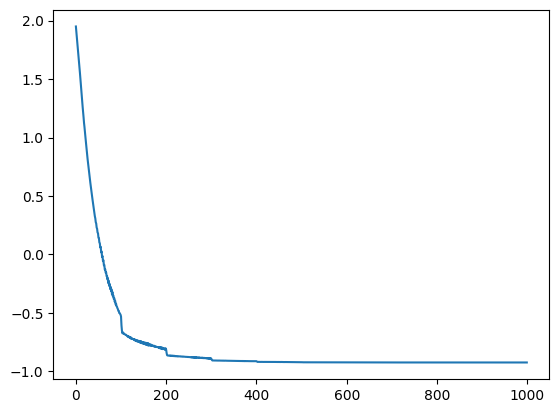

In [12]:
BCE_loss
plt.plot([math.log(x) for x in loss_record])

In [13]:
################## Y_prior##################

y_prior_1= (model_1(train_x1)[0]).detach().squeeze()

y_prior_2= (model_2(train_x2)[0]).detach().squeeze()

y_prior_3= (model_3(train_x2)[0]).detach().squeeze()

BCE_loss_1 = loss_fn(y_prior_1,train_y1)
BCE_loss_2 = loss_fn(y_prior_2, train_y2)
BCE_loss_3 = loss_fn(y_prior_3, train_y3)
BCE_loss=BCE_loss_1+BCE_loss_2+BCE_loss_3
BCE_loss
BCE_loss_1
BCE_loss_2
BCE_loss_3

tensor(2.5123)

tensor(0.0650)

tensor(0.0080)

tensor(2.4394)

(raylet) [2022-10-13 20:28:01,437 E 13617 13651] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-13_20-26-38_159596_13289 is over 95% full, available space: 1091776512; capacity: 29394726912. Object creation will fail if spilling is required.


In [14]:
y_p_1= (model_1(train_x1)[0]>0.5).clone().int()
t_p_1= train_y1.reshape(-1,1).int()

y_p_2= (model_2(train_x2)[0]>0.5).clone().int()
t_p_2= train_y2.reshape(-1,1).int()

y_p_3= (model_3(train_x3)[0]>0.5).clone().int()
t_p_3= train_y3.reshape(-1,1).int()

confusion_matrix(t_p_1,y_p_1)
confusion_matrix(t_p_2,y_p_2)
confusion_matrix(t_p_3,y_p_3)

array([[90,  0],
       [ 0, 70]])

array([[88,  0],
       [ 0, 72]])

array([[69,  0],
       [ 1, 90]])

In [15]:
y_prior_1.squeeze()

tensor([4.2515e-03, 6.6982e-02, 3.7588e-04, 9.9987e-01, 3.4821e-01, 2.1633e-01,
        9.8714e-01, 9.9990e-01, 9.9994e-01, 4.3774e-03, 8.3913e-04, 9.8272e-01,
        1.2135e-02, 1.0807e-02, 3.4033e-02, 6.2095e-02, 1.0000e+00, 9.0194e-01,
        5.0212e-03, 3.7451e-02, 9.8432e-01, 4.4713e-01, 1.4125e-04, 9.6456e-01,
        8.5804e-01, 9.8809e-01, 2.2351e-03, 8.0810e-01, 9.9987e-01, 1.3118e-01,
        7.5878e-01, 1.3384e-01, 9.5908e-01, 3.1481e-02, 2.1358e-03, 1.0486e-01,
        5.4355e-01, 1.7082e-03, 6.9195e-04, 9.8955e-01, 9.8800e-01, 9.7615e-01,
        9.9228e-01, 9.9914e-01, 9.5000e-01, 1.0000e+00, 9.0611e-03, 1.3185e-05,
        4.3297e-04, 1.4032e-02, 8.6022e-03, 8.4106e-05, 1.4105e-01, 9.9591e-01,
        8.8090e-04, 8.0349e-01, 5.9079e-04, 9.8736e-01, 9.9830e-01, 9.9147e-01,
        3.1689e-03, 3.1719e-06, 1.0942e-01, 2.8601e-02, 3.6508e-04, 2.0246e-02,
        2.9829e-01, 5.6287e-05, 8.3212e-01, 9.9974e-01, 4.0545e-02, 2.2258e-05,
        6.1487e-02, 4.3334e-02, 1.0000e+

(raylet) [2022-10-13 20:28:11,450 E 13617 13651] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-13_20-26-38_159596_13289 is over 95% full, available space: 1091104768; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-13 20:28:21,456 E 13617 13651] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-13_20-26-38_159596_13289 is over 95% full, available space: 1089970176; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-13 20:28:31,465 E 13617 13651] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-13_20-26-38_159596_13289 is over 95% full, available space: 1088745472; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-13 20:28:41,473 E 13617 13651] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-13_20-26-38_159596_13289 is over 95% full, available space: 1087991808; capacity: 29394726912. Object creation will fa

In [16]:
################## third step##################

#no prior
prior=0
# switching testing set
test_inputs_1, test_targets_1 = test_x1,test_y1
test_inputs_2, test_targets_2 = test_x2,test_y2
test_inputs_3, test_targets_3 = test_x3,test_y3



# choose lambda1,lambda2 by ray tune
class MLP(torch.nn.Module):
    def __init__(self,seed):
        super(MLP, self).__init__()
        torch.manual_seed(seed)
        self.linear1 = torch.nn.Parameter(torch.randn(p))
        self.linear2 = torch.nn.Linear(p,10)
        self.linear3 = torch.nn.Linear(10,10)
        self.linear4 = torch.nn.Linear(10,1)
    def forward(self, x):
        layer1_out = self.linear1*x
        layer2_out = F.relu(self.linear2(layer1_out))
        layer3_out = F.relu(self.linear3(layer2_out))
        out= torch.sigmoid(self.linear4(layer3_out))
        return out, layer1_out, layer2_out,layer3_out
    
def train_model(config):
    split_num=10
    kf = KFold(n_splits=split_num)
    
    
    lambda1,lambda2,eta = config["lambda1"], config["lambda2"],config["eta"]
    inputs_1,inputs_2,inputs_3=train_x1,train_x2,train_x3
    targets_1=(1-eta)*train_y1+eta*y_prior_1
    targets_2=(1-eta)*train_y2+eta*y_prior_2
    targets_3=(1-eta)*train_y3+eta*y_prior_3
    
    
    
    sum_test_BCE_loss=0
    for idx_train,idx_test in kf.split(inputs_1):
       
        
        model_1=MLP(seed=1)
        model_2=MLP(seed=2)
        model_3=MLP(seed=1)
        max_iteration=1000
        learning_rate=0.8
        params_to_optimize=list(model_1.parameters())+list(model_2.parameters())+list(model_3.parameters())
        optimizer = torch.optim.SGD(params_to_optimize, lr=learning_rate)
        loss_fn = torch.nn.BCELoss()
        scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[100,200,300,400,500,600,700,800], gamma=0.3)

        BCE=[]

        for t in range(max_iteration):
            optimizer.zero_grad() # renew optimizer
            out_1, layer1_out_1, layer2_out_1,layer3_out_1= model_1(inputs_1[idx_train])
            out_2, layer1_out_2, layer2_out_2,layer3_out_2= model_2(inputs_2[idx_train])
            out_3, layer1_out_3, layer2_out_3,layer3_out_3= model_3(inputs_3[idx_train])# forward propagate

            # extract parameters
            #[:-1] for leaving out bias term#
            model_1_all_linear1_params = model_1.linear1
            model_1_all_linear2_params= torch.cat([x.view(-1) for x in model_1.linear2.parameters()][:-1])
            model_1_all_linear3_params= torch.cat([x.view(-1) for x in model_1.linear3.parameters()][:-1])
            model_1_all_linear4_params= torch.cat([x.view(-1) for x in model_1.linear4.parameters()][:-1])
           

            model_2_all_linear1_params = model_1.linear1
            model_2_all_linear2_params= torch.cat([x.view(-1) for x in model_2.linear2.parameters()][:-1])
            model_2_all_linear3_params= torch.cat([x.view(-1) for x in model_2.linear3.parameters()][:-1])
            model_2_all_linear4_params= torch.cat([x.view(-1) for x in model_2.linear4.parameters()][:-1])
    

            model_3_all_linear1_params = model_3.linear1
            model_3_all_linear2_params= torch.cat([x.view(-1) for x in model_3.linear2.parameters()][:-1])
            model_3_all_linear3_params= torch.cat([x.view(-1) for x in model_3.linear3.parameters()][:-1])
            model_3_all_linear4_params= torch.cat([x.view(-1) for x in model_3.linear4.parameters()][:-1])
    


            # compute loss
            all_linear1_params=torch.cat(( model_1_all_linear1_params.reshape(1,-1),  model_2_all_linear1_params.reshape(1,-1), model_3_all_linear1_params.reshape(1,-1)),0)
            all_linear234_params=torch.cat((model_1_all_linear2_params,model_1_all_linear3_params, model_1_all_linear4_params,
                                             model_2_all_linear2_params,model_2_all_linear3_params, model_2_all_linear4_params,
                                             model_3_all_linear2_params,model_3_all_linear3_params,model_3_all_linear4_params),0)

            BCE_loss_1 = loss_fn(out_1, targets_1[idx_train].reshape(-1,1))
            BCE_loss_2 = loss_fn(out_2, targets_2[idx_train].reshape(-1,1))
            BCE_loss_3 = loss_fn(out_3, targets_3[idx_train].reshape(-1,1))

#             l1_regularization = lambda1 * smooth_l1(all_linear1_params,prior)
            l1_regularization = lambda1 * torch.sum(torch.norm(all_linear1_params[:,prior:],p=2,dim=0))

            l2_regularization = lambda2* torch.sum(all_linear234_params.pow(2))
            BCE_loss=BCE_loss_1+BCE_loss_2+BCE_loss_3
            loss =BCE_loss+l1_regularization +l2_regularization

            # record loss
            BCE.append(BCE_loss.item())

            # compute derivative
            loss.backward()

            # gradient descent
            optimizer.step()

            # learning rate decay
            scheduler.step()
        
        
        test_out_1, test_layer1_out_1, test_layer2_out_1,test_layer3_out_1= model_1(train_x1[idx_test])
        test_out_2, test_layer1_out_2, test_layer2_out_2,test_layer3_out_2= model_2(train_x2[idx_test])
        test_out_3, test_layer1_out_3, test_layer2_out_3,test_layer3_out_3= model_3(train_x3[idx_test])
        
#         test_BCE_loss_1 = loss_fn(test_out_1, targets_1[idx_test].reshape(-1,1))
#         test_BCE_loss_2 = loss_fn(test_out_2, targets_1[idx_test].reshape(-1,1))
#         test_BCE_loss_3 = loss_fn(test_out_3, targets_1[idx_test].reshape(-1,1))

        test_BCE_loss_1 = loss_fn(test_out_1, train_y1[idx_test].reshape(-1,1))
        test_BCE_loss_2 = loss_fn(test_out_2, train_y2[idx_test].reshape(-1,1))
        test_BCE_loss_3 = loss_fn(test_out_3, train_y3[idx_test].reshape(-1,1))
        
        test_BCE_loss=test_BCE_loss_1+test_BCE_loss_2+test_BCE_loss_3
        
        sum_test_BCE_loss+=test_BCE_loss.item()

    #print("loss: ",)
    tune.report(my_test_BCE_loss=sum_test_BCE_loss/split_num)
     
        
if __name__ == '__main__':
#     inputs_1,targets_1 = train_x1,train_y1
#     inputs_2,targets_2 = train_x2,train_y2
#     inputs_3,targets_3 = train_x3,train_y3
    #train_model(inputs_1,targets_1,inputs_2,targets_2,inputs_3,targets_3,lambda1=0.1,lambda2=0.06)
    
#     config={
#         "lambda1": tune.choice([0.01,0.02,0.03,0.04,0.05]),
#         "lambda2": tune.choice([0.001,0.002,0.003]),
#         "eta": tune.choice([0.06,0.09,0.1,0.12,0.15,0.17,0.25,0.35,0.45,0.55,0.65,0.75,0.85,0.95])
#     }
    config={
        "lambda1": tune.choice([0.04]),
        "lambda2": tune.choice([0.001,0.002,0.003]),
        "eta": tune.choice([0.06,0.09,0.1,0.12,0.15,0.17,0.25,0.35,0.45,0.55,0.65,0.75,0.85,0.95])
    }


    result = tune.run(
        train_model,  
        config=config,
        num_samples=96)
    
    # 得到最后的结果
    print("======================== Result =========================")
    print(result.results_df)


Trial name,status,loc,eta,lambda1,lambda2,iter,total time (s),my_test_BCE_loss
train_model_9307c_00000,TERMINATED,10.224.0.12:19083,0.55,0.04,0.001,1,55.2644,1.20613
train_model_9307c_00001,TERMINATED,10.224.0.12:19231,0.45,0.04,0.002,1,51.6812,1.19682
train_model_9307c_00002,TERMINATED,10.224.0.12:19233,0.95,0.04,0.002,1,56.0712,1.49307
train_model_9307c_00003,TERMINATED,10.224.0.12:19235,0.25,0.04,0.003,1,51.7008,1.10553
train_model_9307c_00004,TERMINATED,10.224.0.12:19237,0.65,0.04,0.003,1,54.2139,1.24808
train_model_9307c_00005,TERMINATED,10.224.0.12:19239,0.25,0.04,0.001,1,56.4381,1.13947
train_model_9307c_00006,TERMINATED,10.224.0.12:19241,0.25,0.04,0.001,1,56.6074,1.13947
train_model_9307c_00007,TERMINATED,10.224.0.12:19243,0.1,0.04,0.002,1,52.7414,1.07675
train_model_9307c_00008,TERMINATED,10.224.0.12:19246,0.06,0.04,0.002,1,50.1576,1.06025
train_model_9307c_00009,TERMINATED,10.224.0.12:19248,0.25,0.04,0.001,1,55.1401,1.13947


(raylet) [2022-10-13 20:28:51,516 E 13617 13651] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-13_20-26-38_159596_13289 is over 95% full, available space: 1086705664; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-13 20:29:01,600 E 13617 13651] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-13_20-26-38_159596_13289 is over 95% full, available space: 1085820928; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-13 20:29:11,648 E 13617 13651] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-13_20-26-38_159596_13289 is over 95% full, available space: 1084915712; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-13 20:29:21,655 E 13617 13651] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-13_20-26-38_159596_13289 is over 95% full, available space: 1084088320; capacity: 29394726912. Object creation will fa

Result for train_model_9307c_00005:
  date: 2022-10-13_20-29-49
  done: false
  experiment_id: f4ad080771db4c6791a6c8bb502e9a26
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_BCE_loss: 1.1394685089588166
  node_ip: 10.224.0.12
  pid: 19239
  time_since_restore: 56.438148021698
  time_this_iter_s: 56.438148021698
  time_total_s: 56.438148021698
  timestamp: 1665664189
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 9307c_00005
  warmup_time: 0.020896434783935547
  
Result for train_model_9307c_00019:
  date: 2022-10-13_20-29-59
  done: false
  experiment_id: 53fa2ff99ef0419d814857036203436b
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_BCE_loss: 1.4930745005607604
  node_ip: 10.224.0.12
  pid: 19855
  time_since_restore: 47.54979753494263
  time_this_iter_s: 47.54979753494263
  time_total_s: 47.54979753494263
  timestamp: 1665664199
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 9307c_00019
  warmup_ti

Result for train_model_9307c_00012:
  date: 2022-10-13_20-29-50
  done: true
  experiment_id: 46cbf7bbef894ff6a8f10baa2b8e75dd
  experiment_tag: 12_eta=0.9500,lambda1=0.0400,lambda2=0.0010
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_BCE_loss: 1.4988382697105407
  node_ip: 10.224.0.12
  pid: 19255
  time_since_restore: 57.5270516872406
  time_this_iter_s: 57.5270516872406
  time_total_s: 57.5270516872406
  timestamp: 1665664190
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 9307c_00012
  warmup_time: 0.022116899490356445
  
Result for train_model_9307c_00007:
  date: 2022-10-13_20-29-46
  done: false
  experiment_id: e9b79f46e70f46c58b45a6aabccc97a2
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_BCE_loss: 1.0767480432987213
  node_ip: 10.224.0.12
  pid: 19243
  time_since_restore: 52.741421699523926
  time_this_iter_s: 52.741421699523926
  time_total_s: 52.741421699523926
  timestamp: 1665664186
  timesteps_since_res

Result for train_model_9307c_00017:
  date: 2022-10-13_20-29-53
  done: true
  experiment_id: c10ebd0dabd8404e93f19bb1ab76b56f
  experiment_tag: 17_eta=0.6500,lambda1=0.0400,lambda2=0.0020
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_BCE_loss: 1.2414068102836608
  node_ip: 10.224.0.12
  pid: 19663
  time_since_restore: 54.236769676208496
  time_this_iter_s: 54.236769676208496
  time_total_s: 54.236769676208496
  timestamp: 1665664193
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 9307c_00017
  warmup_time: 0.015862226486206055
  
Result for train_model_9307c_00002:
  date: 2022-10-13_20-29-48
  done: true
  experiment_id: 14aa8157512a4be4bdebe330c6338c10
  experiment_tag: 2_eta=0.9500,lambda1=0.0400,lambda2=0.0020
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_BCE_loss: 1.4930745005607604
  node_ip: 10.224.0.12
  pid: 19233
  time_since_restore: 56.071167945861816
  time_this_iter_s: 56.071167945861816
  time_total_s

(raylet) [2022-10-13 20:30:11,928 E 13617 13651] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-13_20-26-38_159596_13289 is over 95% full, available space: 1079975936; capacity: 29394726912. Object creation will fail if spilling is required.


Result for train_model_9307c_00021:
  date: 2022-10-13_20-30-17
  done: false
  experiment_id: 88a4e8da9492481ea833b89d377283a3
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_BCE_loss: 1.0638384222984314
  node_ip: 10.224.0.12
  pid: 19985
  time_since_restore: 52.106231927871704
  time_this_iter_s: 52.106231927871704
  time_total_s: 52.106231927871704
  timestamp: 1665664217
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 9307c_00021
  warmup_time: 0.009750127792358398
  
Result for train_model_9307c_00021:
  date: 2022-10-13_20-30-17
  done: true
  experiment_id: 88a4e8da9492481ea833b89d377283a3
  experiment_tag: 21_eta=0.1200,lambda1=0.0400,lambda2=0.0020
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_BCE_loss: 1.0638384222984314
  node_ip: 10.224.0.12
  pid: 19985
  time_since_restore: 52.106231927871704
  time_this_iter_s: 52.106231927871704
  time_total_s: 52.106231927871704
  timestamp: 1665664217
  timesteps_sin

(raylet) [2022-10-13 20:30:21,963 E 13617 13651] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-13_20-26-38_159596_13289 is over 95% full, available space: 1079246848; capacity: 29394726912. Object creation will fail if spilling is required.


Result for train_model_9307c_00023:
  date: 2022-10-13_20-30-27
  done: false
  experiment_id: e754cb22ac5a4919aae4da5da734e046
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_BCE_loss: 1.105528509616852
  node_ip: 10.224.0.12
  pid: 20105
  time_since_restore: 49.133580923080444
  time_this_iter_s: 49.133580923080444
  time_total_s: 49.133580923080444
  timestamp: 1665664227
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 9307c_00023
  warmup_time: 0.01907205581665039
  
Result for train_model_9307c_00023:
  date: 2022-10-13_20-30-27
  done: true
  experiment_id: e754cb22ac5a4919aae4da5da734e046
  experiment_tag: 23_eta=0.2500,lambda1=0.0400,lambda2=0.0030
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_BCE_loss: 1.105528509616852
  node_ip: 10.224.0.12
  pid: 20105
  time_since_restore: 49.133580923080444
  time_this_iter_s: 49.133580923080444
  time_total_s: 49.133580923080444
  timestamp: 1665664227
  timesteps_since_

(raylet) [2022-10-13 20:30:31,983 E 13617 13651] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-13_20-26-38_159596_13289 is over 95% full, available space: 1078640640; capacity: 29394726912. Object creation will fail if spilling is required.


Result for train_model_9307c_00025:
  date: 2022-10-13_20-30-32
  done: false
  experiment_id: 571e41904e144dfbb34c3f9338ddd9ec
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_BCE_loss: 1.0475755691528321
  node_ip: 10.224.0.12
  pid: 20266
  time_since_restore: 43.05396866798401
  time_this_iter_s: 43.05396866798401
  time_total_s: 43.05396866798401
  timestamp: 1665664232
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 9307c_00025
  warmup_time: 0.00932002067565918
  
Result for train_model_9307c_00025:
  date: 2022-10-13_20-30-32
  done: true
  experiment_id: 571e41904e144dfbb34c3f9338ddd9ec
  experiment_tag: 25_eta=0.1500,lambda1=0.0400,lambda2=0.0030
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_BCE_loss: 1.0475755691528321
  node_ip: 10.224.0.12
  pid: 20266
  time_since_restore: 43.05396866798401
  time_this_iter_s: 43.05396866798401
  time_total_s: 43.05396866798401
  timestamp: 1665664232
  timesteps_since_rest

(raylet) [2022-10-13 20:30:42,015 E 13617 13651] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-13_20-26-38_159596_13289 is over 95% full, available space: 1077460992; capacity: 29394726912. Object creation will fail if spilling is required.


Result for train_model_9307c_00030:
  date: 2022-10-13_20-30-47
  done: false
  experiment_id: 7ab0f5ae69874e6d80c6e7e493f324fe
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_BCE_loss: 1.2973201513290404
  node_ip: 10.224.0.12
  pid: 20459
  time_since_restore: 46.77339196205139
  time_this_iter_s: 46.77339196205139
  time_total_s: 46.77339196205139
  timestamp: 1665664247
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 9307c_00030
  warmup_time: 0.0067827701568603516
  
Result for train_model_9307c_00030:
  date: 2022-10-13_20-30-47
  done: true
  experiment_id: 7ab0f5ae69874e6d80c6e7e493f324fe
  experiment_tag: 30_eta=0.7500,lambda1=0.0400,lambda2=0.0030
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_BCE_loss: 1.2973201513290404
  node_ip: 10.224.0.12
  pid: 20459
  time_since_restore: 46.77339196205139
  time_this_iter_s: 46.77339196205139
  time_total_s: 46.77339196205139
  timestamp: 1665664247
  timesteps_since_re

Result for train_model_9307c_00041:
  date: 2022-10-13_20-30-52
  done: false
  experiment_id: 04b33bef523a4316835052b2b63021a6
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_BCE_loss: 1.1444273173809052
  node_ip: 10.224.0.12
  pid: 19246
  time_since_restore: 46.33036208152771
  time_this_iter_s: 46.33036208152771
  time_total_s: 46.33036208152771
  timestamp: 1665664252
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 9307c_00041
  warmup_time: 0.010615825653076172
  
Result for train_model_9307c_00048:
  date: 2022-10-13_20-30-52
  done: false
  experiment_id: c10ebd0dabd8404e93f19bb1ab76b56f
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_BCE_loss: 1.017468476295471
  node_ip: 10.224.0.12
  pid: 19663
  time_since_restore: 46.147491455078125
  time_this_iter_s: 46.147491455078125
  time_total_s: 46.147491455078125
  timestamp: 1665664252
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 9307c_00048
  w

(raylet) [2022-10-13 20:30:52,109 E 13617 13651] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-13_20-26-38_159596_13289 is over 95% full, available space: 1076285440; capacity: 29394726912. Object creation will fail if spilling is required.


Result for train_model_9307c_00046:
  date: 2022-10-13_20-30-52
  done: false
  experiment_id: 7a87e25656544727b399c7ef0629c148
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_BCE_loss: 1.2973201513290404
  node_ip: 10.224.0.12
  pid: 19235
  time_since_restore: 46.48479080200195
  time_this_iter_s: 46.48479080200195
  time_total_s: 46.48479080200195
  timestamp: 1665664252
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 9307c_00046
  warmup_time: 0.011015892028808594
  
Result for train_model_9307c_00046:
  date: 2022-10-13_20-30-52
  done: true
  experiment_id: 7a87e25656544727b399c7ef0629c148
  experiment_tag: 46_eta=0.7500,lambda1=0.0400,lambda2=0.0030
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_BCE_loss: 1.2973201513290404
  node_ip: 10.224.0.12
  pid: 19235
  time_since_restore: 46.48479080200195
  time_this_iter_s: 46.48479080200195
  time_total_s: 46.48479080200195
  timestamp: 1665664252
  timesteps_since_res

Result for train_model_9307c_00045:
  date: 2022-10-13_20-30-53
  done: false
  experiment_id: e9b79f46e70f46c58b45a6aabccc97a2
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_BCE_loss: 1.0508640825748443
  node_ip: 10.224.0.12
  pid: 19243
  time_since_restore: 48.0749249458313
  time_this_iter_s: 48.0749249458313
  time_total_s: 48.0749249458313
  timestamp: 1665664253
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 9307c_00045
  warmup_time: 0.02468109130859375
  
Result for train_model_9307c_00045:
  date: 2022-10-13_20-30-53
  done: true
  experiment_id: e9b79f46e70f46c58b45a6aabccc97a2
  experiment_tag: 45_eta=0.1500,lambda1=0.0400,lambda2=0.0020
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_BCE_loss: 1.0508640825748443
  node_ip: 10.224.0.12
  pid: 19243
  time_since_restore: 48.0749249458313
  time_this_iter_s: 48.0749249458313
  time_total_s: 48.0749249458313
  timestamp: 1665664253
  timesteps_since_restore: 0

(raylet) [2022-10-13 20:31:02,150 E 13617 13651] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-13_20-26-38_159596_13289 is over 95% full, available space: 1075712000; capacity: 29394726912. Object creation will fail if spilling is required.


Result for train_model_9307c_00054:
  date: 2022-10-13_20-31-02
  done: false
  experiment_id: 0b5452f1096d46ceb2d689196ab25a4a
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_BCE_loss: 1.1814131498336793
  node_ip: 10.224.0.12
  pid: 20031
  time_since_restore: 41.66887927055359
  time_this_iter_s: 41.66887927055359
  time_total_s: 41.66887927055359
  timestamp: 1665664262
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 9307c_00054
  warmup_time: 0.02497553825378418
  
Result for train_model_9307c_00054:
  date: 2022-10-13_20-31-02
  done: true
  experiment_id: 0b5452f1096d46ceb2d689196ab25a4a
  experiment_tag: 54_eta=0.4500,lambda1=0.0400,lambda2=0.0030
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_BCE_loss: 1.1814131498336793
  node_ip: 10.224.0.12
  pid: 20031
  time_since_restore: 41.66887927055359
  time_this_iter_s: 41.66887927055359
  time_total_s: 41.66887927055359
  timestamp: 1665664262
  timesteps_since_rest

(raylet) [2022-10-13 20:31:12,156 E 13617 13651] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-13_20-26-38_159596_13289 is over 95% full, available space: 1074900992; capacity: 29394726912. Object creation will fail if spilling is required.


Result for train_model_9307c_00059:
  date: 2022-10-13_20-31-12
  done: false
  experiment_id: 8a8dfb0f40794ae3a94c651b8af1de53
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_BCE_loss: 1.105528509616852
  node_ip: 10.224.0.12
  pid: 20315
  time_since_restore: 33.19136714935303
  time_this_iter_s: 33.19136714935303
  time_total_s: 33.19136714935303
  timestamp: 1665664272
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 9307c_00059
  warmup_time: 0.014173746109008789
  
Result for train_model_9307c_00059:
  date: 2022-10-13_20-31-12
  done: true
  experiment_id: 8a8dfb0f40794ae3a94c651b8af1de53
  experiment_tag: 59_eta=0.2500,lambda1=0.0400,lambda2=0.0030
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_BCE_loss: 1.105528509616852
  node_ip: 10.224.0.12
  pid: 20315
  time_since_restore: 33.19136714935303
  time_this_iter_s: 33.19136714935303
  time_total_s: 33.19136714935303
  timestamp: 1665664272
  timesteps_since_resto

2022-10-13 20:31:15,078	INFO tune.py:758 -- Total run time: 152.33 seconds (152.06 seconds for the tuning loop).


======================== Result =========================
             my_test_BCE_loss  time_this_iter_s  done timesteps_total  \
trial_id                                                                
9307c_00000          1.206128         55.264435  True            None   
9307c_00001          1.196823         51.681201  True            None   
9307c_00002          1.493075         56.071168  True            None   
9307c_00003          1.105529         51.700786  True            None   
9307c_00004          1.248084         54.213908  True            None   
...                       ...               ...   ...             ...   
9307c_00059          1.105529         33.191367  True            None   
9307c_00060          1.144892         32.529247  True            None   
9307c_00061          1.187628         31.344516  True            None   
9307c_00062          1.498838         27.594400  True            None   
9307c_00063          1.157912         27.209414  True            N

(raylet) [2022-10-13 20:31:22,162 E 13617 13651] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-13_20-26-38_159596_13289 is over 95% full, available space: 1072746496; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-13 20:31:32,171 E 13617 13651] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-13_20-26-38_159596_13289 is over 95% full, available space: 1072345088; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-13 20:31:42,188 E 13617 13651] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-13_20-26-38_159596_13289 is over 95% full, available space: 1070985216; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-13 20:31:52,200 E 13617 13651] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-13_20-26-38_159596_13289 is over 95% full, available space: 1069629440; capacity: 29394726912. Object creation will fa

In [17]:
best_trial = result.get_best_trial("my_test_BCE_loss", "min", "last")
print("Best trial final validation loss: {}".format(best_trial.last_result["my_test_BCE_loss"]))
final_parameter=result.get_best_config('my_test_BCE_loss',mode='min')
final_parameter

Best trial final validation loss: 1.017468476295471


{'lambda1': 0.04, 'lambda2': 0.003, 'eta': 0.06}

(raylet) [2022-10-13 20:32:02,207 E 13617 13651] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-13_20-26-38_159596_13289 is over 95% full, available space: 1069338624; capacity: 29394726912. Object creation will fail if spilling is required.


In [26]:
################## second step##################

#no prior
prior=0

#0.4,0.4
# set hyperparamters
final_parameter=result.get_best_config('my_test_BCE_loss',mode='min')
lambda1,lambda2,eta=final_parameter["lambda1"],final_parameter["lambda2"],final_parameter["eta"]
learning_rate=0.8
max_iteration=1000


inputs_1,inputs_2,inputs_3=train_x1,train_x2,train_x3
targets_1=(1-eta)*train_y1+eta*y_prior_1
targets_2=(1-eta)*train_y2+eta*y_prior_2
targets_3=(1-eta)*train_y3+eta*y_prior_3

# switching testing set
test_inputs_1, test_targets_1 = test_x1,test_y1
test_inputs_2, test_targets_2 = test_x2,test_y2
test_inputs_3, test_targets_3 = test_x3,test_y3

# record loss descent
BCE=[]


# main nn object
class MLP(torch.nn.Module):
    def __init__(self,seed):
        super(MLP, self).__init__()
        torch.manual_seed(seed)
        self.linear1 = torch.nn.Parameter(torch.randn(p))
        self.linear2 = torch.nn.Linear(p,10)
        self.linear3 = torch.nn.Linear(10,10)
        self.linear4 = torch.nn.Linear(10,1)

    def forward(self, x):
        layer1_out = self.linear1*x
        layer2_out = F.relu(self.linear2(layer1_out))
        layer3_out = F.relu(self.linear3(layer2_out))
        out= torch.sigmoid(self.linear4(layer3_out))
        return out, layer1_out, layer2_out,layer3_out
    


model_1=MLP(seed=1)
model_2=MLP(seed=2)
model_3=MLP(seed=1)

loss_fn = torch.nn.BCELoss()
params_to_optimize=list(model_1.parameters())+list(model_2.parameters())+list(model_3.parameters())
optimizer = torch.optim.SGD(params_to_optimize, lr=learning_rate)

# learning rate decay scheme
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[100,200,300,400,500,600,700,800], gamma=0.3)

loss_record=[]
# loop for max_iteration times
for t in range(max_iteration):
    
    # renew optimizer
    optimizer.zero_grad()
    
    # forward propagate
    out_1, layer1_out_1, layer2_out_1,layer3_out_1= model_1(inputs_1)
    out_2, layer1_out_2, layer2_out_2,layer3_out_2= model_2(inputs_2)
    out_3, layer1_out_3, layer2_out_3,layer3_out_3= model_3(inputs_3)
    
    
    
    # extract parameters
    #[:-1] for leaving out bias term#
    model_1_all_linear1_params = model_1.linear1
    model_1_all_linear2_params= torch.cat([x.view(-1) for x in model_1.linear2.parameters()][:-1])
    model_1_all_linear3_params= torch.cat([x.view(-1) for x in model_1.linear3.parameters()][:-1])
    model_1_all_linear4_params= torch.cat([x.view(-1) for x in model_1.linear4.parameters()][:-1])
    
    model_2_all_linear1_params = model_1.linear1
    model_2_all_linear2_params= torch.cat([x.view(-1) for x in model_2.linear2.parameters()][:-1])
    model_2_all_linear3_params= torch.cat([x.view(-1) for x in model_2.linear3.parameters()][:-1])
    model_2_all_linear4_params= torch.cat([x.view(-1) for x in model_2.linear4.parameters()][:-1])
    
    model_3_all_linear1_params = model_3.linear1
    model_3_all_linear2_params= torch.cat([x.view(-1) for x in model_3.linear2.parameters()][:-1])
    model_3_all_linear3_params= torch.cat([x.view(-1) for x in model_3.linear3.parameters()][:-1])
    model_3_all_linear4_params= torch.cat([x.view(-1) for x in model_3.linear4.parameters()][:-1])
    

    # compute loss

    all_linear1_params=torch.cat(( model_1_all_linear1_params.reshape(1,-1),  model_2_all_linear1_params.reshape(1,-1), model_3_all_linear1_params.reshape(1,-1)),0)
    all_linear234_params=torch.cat((model_1_all_linear2_params,model_1_all_linear3_params, model_1_all_linear4_params,
                                     model_2_all_linear2_params,model_2_all_linear3_params, model_2_all_linear4_params,
                                     model_3_all_linear2_params,model_3_all_linear3_params,model_3_all_linear4_params),0)
    
    BCE_loss_1 = loss_fn(out_1, targets_1.reshape(-1,1))
    BCE_loss_2 = loss_fn(out_2, targets_2.reshape(-1,1))
    BCE_loss_3 = loss_fn(out_3, targets_3.reshape(-1,1))
    
#     l1_regularization = lambda1 * smooth_l1(all_linear1_params,prior)
    
    l1_regularization = lambda1 * torch.sum(torch.norm(all_linear1_params[:,prior:],p=2,dim=0))
    
    l2_regularization = lambda2 * torch.sum(all_linear234_params.pow(2))
    BCE_loss=BCE_loss_1+BCE_loss_2+BCE_loss_3
    loss =BCE_loss+l1_regularization +l2_regularization
    
    loss_record.append(loss.item())
    # record loss
    BCE.append(BCE_loss.item())
    
    # compute derivative
    loss.backward()
    
    # gradient descent
    optimizer.step()
    
    # learning rate decay
    scheduler.step()


(raylet) [2022-10-13 20:33:42,356 E 13617 13651] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-13_20-26-38_159596_13289 is over 95% full, available space: 1058607104; capacity: 29394726912. Object creation will fail if spilling is required.


tensor(0.3143, grad_fn=<AddBackward0>)

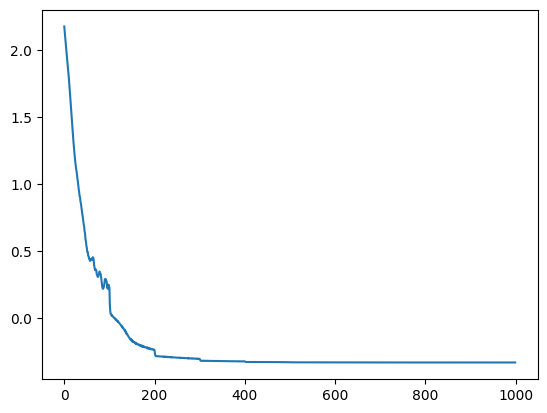

In [27]:
BCE_loss
plt.plot([math.log(x) for x in loss_record])

In [28]:
model_1_all_linear1_params.reshape(1,-1)
model_2_all_linear1_params.reshape(1,-1)
model_3_all_linear1_params.reshape(1,-1)

tensor([[-1.3224e-01, -1.7194e-01, -2.3181e-01, -1.3537e-01, -2.1907e-01,
         -2.2274e-01, -1.5062e-01, -1.3980e-01, -1.8796e-01, -1.5212e-01,
          1.8022e-06, -4.3353e-06,  3.1701e-06,  1.6131e-03,  2.6352e-07,
          3.3984e-06, -2.9198e-06,  8.1898e-07, -8.9321e-07,  2.3307e-06,
         -1.1203e-06, -4.8604e-07, -5.2790e-07,  2.3210e-06,  1.7090e-06,
         -2.5853e-06,  1.1761e-06, -2.0082e-06,  1.1677e-06,  3.5178e-06,
         -5.2892e-07, -5.5423e-07,  1.9633e-07,  2.3397e-06, -2.2227e-06,
          2.0875e-06,  2.3557e-06,  9.6754e-07,  3.2441e-06,  6.8305e-07,
          3.0784e-06, -1.4211e-06,  2.2581e-06, -1.7535e-06,  2.1397e-06,
          2.4142e-06,  3.0386e-07, -4.5237e-07, -2.9991e-06, -2.3629e-06,
          3.0263e-06, -1.5782e-06, -1.4695e-07,  4.8301e-08, -3.3675e-06,
          1.9188e-06, -1.5214e-06,  2.2600e-06,  2.9203e-06, -2.6993e-06,
         -3.4869e-06,  7.3653e-08, -2.0492e-04,  4.5272e-07, -1.3294e-07,
         -2.4763e-06,  3.1622e-06,  2.

tensor([[-1.3224e-01, -1.7194e-01, -2.3181e-01, -1.3537e-01, -2.1907e-01,
         -2.2274e-01, -1.5062e-01, -1.3980e-01, -1.8796e-01, -1.5212e-01,
          1.8022e-06, -4.3353e-06,  3.1701e-06,  1.6131e-03,  2.6352e-07,
          3.3984e-06, -2.9198e-06,  8.1898e-07, -8.9321e-07,  2.3307e-06,
         -1.1203e-06, -4.8604e-07, -5.2790e-07,  2.3210e-06,  1.7090e-06,
         -2.5853e-06,  1.1761e-06, -2.0082e-06,  1.1677e-06,  3.5178e-06,
         -5.2892e-07, -5.5423e-07,  1.9633e-07,  2.3397e-06, -2.2227e-06,
          2.0875e-06,  2.3557e-06,  9.6754e-07,  3.2441e-06,  6.8305e-07,
          3.0784e-06, -1.4211e-06,  2.2581e-06, -1.7535e-06,  2.1397e-06,
          2.4142e-06,  3.0386e-07, -4.5237e-07, -2.9991e-06, -2.3629e-06,
          3.0263e-06, -1.5782e-06, -1.4695e-07,  4.8301e-08, -3.3675e-06,
          1.9188e-06, -1.5214e-06,  2.2600e-06,  2.9203e-06, -2.6993e-06,
         -3.4869e-06,  7.3653e-08, -2.0492e-04,  4.5272e-07, -1.3294e-07,
         -2.4763e-06,  3.1622e-06,  2.

tensor([[-1.6233e-01, -1.9587e-01, -2.5916e-01, -1.8760e-01,  2.0234e-01,
         -2.8811e-01, -1.6829e-01, -1.5864e-01, -1.9511e-01, -2.0885e-01,
         -7.4082e-07,  4.7620e-08, -1.0812e-06,  5.5195e-02, -2.3771e-08,
         -9.0236e-08,  1.3827e-07,  7.2460e-07,  3.0162e-09,  1.3216e-06,
          3.9731e-09,  8.2863e-08, -5.9213e-08, -2.6261e-07,  1.3047e-06,
          1.5563e-07, -2.0507e-07, -6.7900e-07,  2.2634e-09, -1.8418e-08,
          8.7203e-08,  3.3471e-07,  3.1575e-07, -1.6164e-09,  4.0418e-07,
          1.2492e-07,  5.5287e-08, -8.0166e-08, -1.6969e-07, -3.3693e-07,
          1.2680e-06,  5.8975e-09, -3.4334e-08,  1.8910e-08,  7.2931e-08,
         -1.1847e-07,  4.2435e-08, -5.2915e-08,  1.4443e-06, -6.4321e-08,
          1.3110e-07,  4.2155e-08, -7.0955e-08, -3.2697e-08,  2.8889e-07,
          2.3225e-07,  7.9864e-07,  4.0749e-07, -2.0450e-07, -1.2445e-08,
         -1.4153e-07,  1.1913e-08, -1.5221e-02, -4.3523e-08,  1.1153e-07,
         -8.3237e-08,  5.2307e-07, -6.

In [29]:

model_1(test_x1)[0].squeeze()
test_y1.squeeze()
model_2(test_x2)[0].squeeze()
test_y2.squeeze()
model_3(test_x3)[0].squeeze()
test_y3.squeeze()


tensor([9.8258e-01, 9.8448e-01, 1.4475e-01, 6.4906e-01, 9.9550e-04, 9.8341e-01,
        9.3870e-01, 4.9658e-02, 9.7986e-01, 8.5793e-01, 9.6357e-06, 9.7948e-01,
        9.8904e-01, 1.2410e-02, 5.2195e-01, 9.6803e-01, 7.7799e-02, 9.2974e-01,
        1.1456e-02, 4.5769e-03, 2.8558e-03, 9.7456e-01, 9.6879e-01, 4.8469e-01,
        7.4973e-01, 2.4766e-01, 2.1358e-01, 1.9154e-02, 5.4697e-01, 3.1625e-01,
        1.5176e-01, 1.7361e-01, 7.6565e-04, 5.1602e-01, 1.4625e-01, 8.0576e-01,
        9.3023e-01, 9.5471e-01, 2.5947e-01, 5.5224e-04],
       grad_fn=<SqueezeBackward0>)

tensor([1., 1., 0., 1., 0., 1., 1., 0., 1., 1., 0., 1., 1., 0., 1., 1., 0., 1.,
        0., 0., 0., 1., 1., 0., 1., 0., 0., 0., 1., 1., 0., 0., 0., 1., 0., 1.,
        1., 1., 1., 0.])

tensor([4.4424e-03, 9.9977e-01, 9.8448e-01, 9.6298e-01, 8.7725e-01, 9.9870e-01,
        9.8199e-01, 9.9812e-01, 2.8426e-02, 4.0779e-04, 5.8746e-02, 9.9150e-01,
        4.1013e-04, 9.8026e-01, 2.1080e-01, 8.7118e-01, 9.8871e-01, 9.9168e-01,
        3.0962e-02, 9.9705e-01, 9.8552e-01, 3.0163e-01, 3.1370e-02, 1.2260e-03,
        9.5283e-01, 2.6784e-04, 6.8636e-01, 2.0122e-02, 3.7746e-02, 1.5018e-01,
        9.9224e-01, 9.9294e-01, 8.2814e-01, 5.3218e-01, 9.9827e-01, 9.9634e-01,
        9.9871e-01, 4.5235e-03, 9.9821e-01, 9.7876e-01],
       grad_fn=<SqueezeBackward0>)

tensor([0., 1., 1., 1., 1., 1., 0., 1., 0., 0., 0., 1., 0., 0., 1., 0., 1., 1.,
        1., 1., 1., 1., 0., 0., 1., 0., 1., 0., 0., 1., 1., 1., 1., 0., 1., 1.,
        1., 0., 1., 1.])

tensor([0.5358, 0.9676, 0.9515, 0.9613, 0.0205, 0.2105, 0.6404, 0.1669, 0.9574,
        0.9465, 0.9158, 0.0969, 0.9748, 0.4931, 0.9718, 0.1001, 0.9726, 0.9371,
        0.9447, 0.9721, 0.7273, 0.4712, 0.8987, 0.8661, 0.0909, 0.0180, 0.0128,
        0.9672, 0.5421, 0.9582, 0.7320, 0.0029, 0.8888, 0.9112, 0.0195, 0.0990,
        0.4405, 0.8577, 0.5059, 0.1427], grad_fn=<SqueezeBackward0>)

tensor([0., 1., 1., 1., 0., 0., 0., 0., 1., 1., 1., 0., 1., 1., 1., 0., 1., 1.,
        1., 1., 1., 0., 1., 1., 0., 0., 0., 1., 1., 1., 1., 0., 1., 1., 0., 0.,
        0., 0., 0., 0.])

In [30]:
################## third step ##################
################## testing stage ##################

prediction_1= (model_1(test_x1)[0]>0.5).clone().int()
target_1= test_y1.reshape(-1,1).int()

prediction_2= (model_2(test_x2)[0]>0.5).clone().int()
target_2= test_y2.reshape(-1,1).int()

prediction_3= (model_3(test_x3)[0]>0.5).clone().int()
target_3= test_y3.reshape(-1,1).int()

prediction=np.append(prediction_1,prediction_2)
prediction=np.append(prediction,prediction_3)
prediction=prediction.tolist()

target=np.append(target_1,target_2)
target=np.append(target,target_3)
target=target.tolist()

final_matrix=confusion_matrix(target,prediction)
final_matrix
recall_score(target,prediction)#TPR
final_matrix[0,0]/(sum(final_matrix[0,:]))#TNR
accuracy_score(target,prediction)
precision_score(target,prediction)
f1_score(target,prediction)

array([[43,  8],
       [ 7, 62]])

0.8985507246376812

0.8431372549019608

0.875

0.8857142857142857

0.8920863309352518

(raylet) [2022-10-13 20:33:52,371 E 13617 13651] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-13_20-26-38_159596_13289 is over 95% full, available space: 1057320960; capacity: 29394726912. Object creation will fail if spilling is required.


In [31]:
final_matrix_1=confusion_matrix(target_1,prediction_1)
final_matrix_1
recall_score(target_1,prediction_1)#TPR
final_matrix_1[0,0]/(sum(final_matrix_1[0,:]))#TNR

final_matrix_2=confusion_matrix(target_2,prediction_2)
final_matrix_2
recall_score(target_2,prediction_2)#TPR
final_matrix_2[0,0]/(sum(final_matrix_2[0,:]))#TNR

final_matrix_3=confusion_matrix(target_3,prediction_3)
final_matrix_3
recall_score(target_3,prediction_3)#TPR
final_matrix_3[0,0]/(sum(final_matrix_3[0,:]))#TNR

array([[18,  0],
       [ 2, 20]])

0.9090909090909091

1.0

array([[11,  4],
       [ 4, 21]])

0.84

0.7333333333333333

array([[14,  4],
       [ 1, 21]])

0.9545454545454546

0.7777777777777778

In [32]:
# variable selection evaluation

def cubic_root(x):
    return math.copysign(math.pow(abs(x), 1.0/3.0), x)

model_1_weight=model_1_all_linear1_params.detach().numpy().copy().reshape(1,-1)
model_2_weight=model_2_all_linear1_params.detach().numpy().copy().reshape(1,-1)
model_3_weight=model_3_all_linear1_params.detach().numpy().copy().reshape(1,-1)

model_1_weight
model_2_weight
model_3_weight

array([[-1.3223961e-01, -1.7194076e-01, -2.3181246e-01, -1.3536957e-01,
        -2.1906586e-01, -2.2273824e-01, -1.5061909e-01, -1.3980061e-01,
        -1.8795599e-01, -1.5212137e-01,  1.8022176e-06, -4.3352688e-06,
         3.1701270e-06,  1.6130910e-03,  2.6352325e-07,  3.3983733e-06,
        -2.9197952e-06,  8.1897963e-07, -8.9321026e-07,  2.3307255e-06,
        -1.1202528e-06, -4.8604102e-07, -5.2790159e-07,  2.3210041e-06,
         1.7089617e-06, -2.5853428e-06,  1.1760585e-06, -2.0081877e-06,
         1.1677055e-06,  3.5177979e-06, -5.2892204e-07, -5.5422885e-07,
         1.9632961e-07,  2.3396890e-06, -2.2227241e-06,  2.0875354e-06,
         2.3556581e-06,  9.6754070e-07,  3.2441146e-06,  6.8304792e-07,
         3.0784065e-06, -1.4210980e-06,  2.2580689e-06, -1.7535249e-06,
         2.1397132e-06,  2.4142132e-06,  3.0386408e-07, -4.5236737e-07,
        -2.9990586e-06, -2.3628627e-06,  3.0263086e-06, -1.5782325e-06,
        -1.4695186e-07,  4.8301324e-08, -3.3675490e-06,  1.91879

array([[-1.3223961e-01, -1.7194076e-01, -2.3181246e-01, -1.3536957e-01,
        -2.1906586e-01, -2.2273824e-01, -1.5061909e-01, -1.3980061e-01,
        -1.8795599e-01, -1.5212137e-01,  1.8022176e-06, -4.3352688e-06,
         3.1701270e-06,  1.6130910e-03,  2.6352325e-07,  3.3983733e-06,
        -2.9197952e-06,  8.1897963e-07, -8.9321026e-07,  2.3307255e-06,
        -1.1202528e-06, -4.8604102e-07, -5.2790159e-07,  2.3210041e-06,
         1.7089617e-06, -2.5853428e-06,  1.1760585e-06, -2.0081877e-06,
         1.1677055e-06,  3.5177979e-06, -5.2892204e-07, -5.5422885e-07,
         1.9632961e-07,  2.3396890e-06, -2.2227241e-06,  2.0875354e-06,
         2.3556581e-06,  9.6754070e-07,  3.2441146e-06,  6.8304792e-07,
         3.0784065e-06, -1.4210980e-06,  2.2580689e-06, -1.7535249e-06,
         2.1397132e-06,  2.4142132e-06,  3.0386408e-07, -4.5236737e-07,
        -2.9990586e-06, -2.3628627e-06,  3.0263086e-06, -1.5782325e-06,
        -1.4695186e-07,  4.8301324e-08, -3.3675490e-06,  1.91879

array([[-1.6233484e-01, -1.9586505e-01, -2.5916344e-01, -1.8759939e-01,
         2.0233835e-01, -2.8810853e-01, -1.6828966e-01, -1.5864466e-01,
        -1.9510627e-01, -2.0884855e-01, -7.4082425e-07,  4.7620407e-08,
        -1.0812208e-06,  5.5195227e-02, -2.3770925e-08, -9.0236384e-08,
         1.3826855e-07,  7.2460267e-07,  3.0161780e-09,  1.3215873e-06,
         3.9730508e-09,  8.2862684e-08, -5.9212873e-08, -2.6261065e-07,
         1.3046831e-06,  1.5563127e-07, -2.0507368e-07, -6.7900271e-07,
         2.2634428e-09, -1.8418058e-08,  8.7203304e-08,  3.3470738e-07,
         3.1575192e-07, -1.6163627e-09,  4.0417544e-07,  1.2491849e-07,
         5.5286559e-08, -8.0165684e-08, -1.6969226e-07, -3.3692672e-07,
         1.2680035e-06,  5.8974901e-09, -3.4334484e-08,  1.8910457e-08,
         7.2930902e-08, -1.1847163e-07,  4.2434838e-08, -5.2914682e-08,
         1.4442747e-06, -6.4320510e-08,  1.3110039e-07,  4.2154625e-08,
        -7.0955117e-08, -3.2696949e-08,  2.8889389e-07,  2.32254

In [35]:
threshold=0.1
mcl_w=np.zeros(p)

for i in range(p):
    mcl_w[i]=cubic_root(model_1_weight[0,i]*model_2_weight[0,i]*model_3_weight[0,i])

max_mcl_w=max(abs(mcl_w))
for i in range(p):
    if (abs(mcl_w[i]))<=threshold*max_mcl_w:
        model_1_weight[0,i]=0
        model_2_weight[0,i]=0
        model_3_weight[0,i]=0
    else:
        model_1_weight[0,i]=model_1_weight[0,i]
        model_2_weight[0,i]=model_2_weight[0,i]
        model_3_weight[0,i]=model_3_weight[0,i]
index=np.nonzero(model_1_weight)[1]
model_1_weight
final_index=index+1
final_index
len(index)

array([[-0.13223961, -0.17194076, -0.23181246, -0.13536957, -0.21906586,
        -0.22273824, -0.15061909, -0.13980061, -0.18795599, -0.15212137,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0. 

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 71])

11

(raylet) [2022-10-13 20:34:32,424 E 13617 13651] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-13_20-26-38_159596_13289 is over 95% full, available space: 1052979200; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-13 20:34:42,439 E 13617 13651] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-13_20-26-38_159596_13289 is over 95% full, available space: 1052094464; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-13 20:34:52,451 E 13617 13651] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-13_20-26-38_159596_13289 is over 95% full, available space: 1050562560; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-13 20:35:02,458 E 13617 13651] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-13_20-26-38_159596_13289 is over 95% full, available space: 1049997312; capacity: 29394726912. Object creation will fa

(raylet) [2022-10-13 20:39:42,739 E 13617 13651] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-13_20-26-38_159596_13289 is over 95% full, available space: 1021104128; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-13 20:39:52,747 E 13617 13651] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-13_20-26-38_159596_13289 is over 95% full, available space: 1020579840; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-13 20:40:02,762 E 13617 13651] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-13_20-26-38_159596_13289 is over 95% full, available space: 1019772928; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-13 20:40:12,771 E 13617 13651] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-13_20-26-38_159596_13289 is over 95% full, available space: 1018974208; capacity: 29394726912. Object creation will fa

(raylet) [2022-10-13 20:44:53,035 E 13617 13651] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-13_20-26-38_159596_13289 is over 95% full, available space: 1003585536; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-13 20:45:03,043 E 13617 13651] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-13_20-26-38_159596_13289 is over 95% full, available space: 1003331584; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-13 20:45:13,050 E 13617 13651] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-13_20-26-38_159596_13289 is over 95% full, available space: 1003106304; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-13 20:45:23,057 E 13617 13651] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-13_20-26-38_159596_13289 is over 95% full, available space: 1002856448; capacity: 29394726912. Object creation will fa

(raylet) [2022-10-13 20:50:03,250 E 13617 13651] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-13_20-26-38_159596_13289 is over 95% full, available space: 996098048; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-13 20:50:13,256 E 13617 13651] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-13_20-26-38_159596_13289 is over 95% full, available space: 995885056; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-13 20:50:23,264 E 13617 13651] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-13_20-26-38_159596_13289 is over 95% full, available space: 995655680; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-13 20:50:33,271 E 13617 13651] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-13_20-26-38_159596_13289 is over 95% full, available space: 995430400; capacity: 29394726912. Object creation will fail i

(raylet) [2022-10-13 20:55:13,469 E 13617 13651] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-13_20-26-38_159596_13289 is over 95% full, available space: 982708224; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-13 20:55:23,477 E 13617 13651] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-13_20-26-38_159596_13289 is over 95% full, available space: 982466560; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-13 20:55:33,484 E 13617 13651] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-13_20-26-38_159596_13289 is over 95% full, available space: 982253568; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-13 20:55:43,492 E 13617 13651] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-13_20-26-38_159596_13289 is over 95% full, available space: 981991424; capacity: 29394726912. Object creation will fail i

(raylet) [2022-10-13 21:00:23,695 E 13617 13651] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-13_20-26-38_159596_13289 is over 95% full, available space: 971608064; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-13 21:00:33,702 E 13617 13651] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-13_20-26-38_159596_13289 is over 95% full, available space: 971378688; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-13 21:00:43,709 E 13617 13651] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-13_20-26-38_159596_13289 is over 95% full, available space: 971091968; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-13 21:00:53,716 E 13617 13651] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-13_20-26-38_159596_13289 is over 95% full, available space: 970903552; capacity: 29394726912. Object creation will fail i